<a href="https://colab.research.google.com/github/je-santos/MPLBM-UT/blob/master/examples/create_2D_training_data_4NN/VelNet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to neural networks using Digital Rocks
© Javier E. Santos and Bernard Chang 2020. Apache License 2.0.

-------------------------------------------------------------------------
Throughout this notebook we will develop and train neural networks for different petrophysical applications. We will attempt to provide the user with intuition behind how these networks work and best training practices. Let's keep in mind that this notebook is intended to be executed in a 2-hr workshop, so many important concepts will be neglected for the sake of brevity.

-------------------------------------------------------------------------
A great comprehensive resource is the convolutional neural network class (CS321N) from Stanford University. This can be streamed here: [CS321N youtube playlist link](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv). Many of the concepts shown in this notebook were originally develope for the a 3D ConvNet called the [PoreFlow-net](https://www.sciencedirect.com/science/article/pii/S0309170819311145).

In [6]:
# @title Importing libraries and downloading data (run me first!)
%%capture

!pip install git+https://github.com/je-santos/livelossplot

import os
import sys
import random
import copy

# Importing the numerical and viz libs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import seaborn as sns
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display

# Importing utilities libs 
import glob
from PIL import Image

# Importing the ML libs
import sklearn
import tensorflow as tf
from tensorflow import keras
keras.backend.set_epsilon = 1e-4


# more libraries
!pip install scikit-fmm
import skfmm
import scipy.ndimage as sc
import time
!pip install porespy
import porespy as ps


from livelossplot import PlotLossesKeras
from livelossplot.plot_losses  import MatplotlibPlot
    
import warnings
warnings.simplefilter("ignore")

# function to calculate the relative error
def calc_errror(y,y_pred,epsilon=1e-4, reduction = 'mean'):
    rel_error = np.abs(y-y_pred)/np.clip(np.abs(y),a_min=epsilon,a_max=None)*100 
    if reduction == 'mean':
        return rel_error.mean()
    elif reduction == 'none':
        return rel_error()


try:
  os.mkdir('numpys')
except:
  pass 


!git clone https://github.com/je-santos/PoreFlow-Net.git
!mv PoreFlow-Net/ilustrations/numpys.zip numpys/numpys.zip
os.chdir('numpys')


from zipfile import ZipFile
with ZipFile('numpys.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
os.chdir('..')




  Cloning https://github.com/je-santos/livelossplot to c:\users\jae3287\appdata\local\temp\pip-req-build-2wb1ghg4
  Created wheel for livelossplot: filename=livelossplot-0.5.0-py3-none-any.whl size=20505 sha256=66434e32cbb120067ccd4b36790def9144aa9a5914cfff93165d9431e3d830f3
  Stored in directory: C:\Users\jae3287\AppData\Local\Temp\pip-ephem-wheel-cache-3m_6yexa\wheels\d1\85\7f\91c563589b9efae46dcb114d7983ea917ecaa1f37efb85023c
Successfully built livelossplot


ImportError: cannot import name '_validate_lengths' from 'numpy.lib.arraypad' (C:\Users\jae3287\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraypad.py)

# 1.0 Introduction

Where are we?

![](https://www.google.com/images/logos/google_logo_41.png) Colab
- Google colab is an enviroment by that allows to write and execute python code directly in a browser. It doesn't require any prior configuration or software installation.

    - It also provides free GPU access: Runtime -> change runtime type

In [15]:
print(f'This is a code cell. One can perform operations here: 1+3 = {1+3}')
# One can you this cell with the play button or with shift+enter

This is a code cell. One can perform operations here: 1+3 = 4


<-- To the left there is button to display the table of contents, in case anyone gets lost along the way

A very common error is:

In [28]:
raise NameError('x is not defined')

NameError: x is not defined

This is likely to happen when previous cells of code were not run.

## 1.1 What's a neuron?

A neuron performs a mathematical operation where the input data ($x$) is multiplied by a $\textit{weight}$ ($w$) followed by the addition of a $\textit{bias term}$ ($b$). These are called $\textit{trainable parameters}$.

$y=x*w+b$

Additionally, this ouput  can passed through a non-linear activation function.

$y_{_{NL}} = f(y)$

Some examples of non-linearities commonly used in NN are the following:

- $ReLU(y)     = max(0, y)$

- $sigmoid(y) = 1 / (1 + exp(-y))$

Each function has distint properties that can benefit certain applications.

IntRangeSlider(value=(-6, 6), description='Input range:', max=10, min=-10)

FloatSlider(value=2.0, description='Weight value:', max=5.0, min=-5.0)

FloatSlider(value=0.0, description='Bias value:', max=5.0, min=-5.0)

RadioButtons(description='Activation:', index=1, options=('linear', 'sigmoid', 'ReLU'), value='sigmoid')

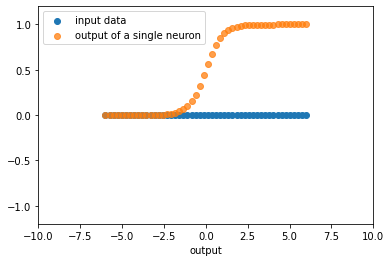

In [9]:
## @title 1.2 A single neuron

xi = widgets.IntRangeSlider()
xi.min = -10
xi.max =  10
xi.value= [-2, 2]
xi.description='Input range:'
display(xi)


w = widgets.FloatSlider()
w.value= 1
w.min = -5
w.max =  5
w.description='Weight value:'
display(w)

b = widgets.FloatSlider()
b.value= 0
b.min = -5
b.max =  5
b.description='Bias value:'
display(b)

act = widgets.RadioButtons()
act.options=['linear','sigmoid','ReLU']
act.description = 'Activation:'
display(act)

    
def plot_w(*args):
    print(f'Hi my first value is {xi.value[0]}')
    x_t = np.linspace(xi.value[0],xi.value[1])
    y_t = x_t*w.value+b.value
    lim = ([-50, 50])
    if act.value=='sigmoid':
        y_t = 1 / (1 + np.exp(-y_t))
        lim = ([-0.5, 1.2])
    if act.value=='ReLU':
        y_t = np.maximum(y_t,0)

    #plt.figure(1)
    #plt.close()
    clear_output(wait=True)
    display(xi,w,b,act)
    plt.scatter(x_t, np.zeros_like(x_t))
    plt.scatter(x_t, y_t,alpha=0.75)
    plt.ylim(lim)
    plt.xlim([-10 ,10])
    plt.legend(['input data','output of a single neuron'])
    plt.xlabel('input')
    plt.ylabel('output')
    plt.show()

plot_w()
    
xi.observe(plot_w,'value')
w.observe(plot_w,'value')
b.observe(plot_w,'value')
act.observe(plot_w,'value')


The neuron is the basic building block in neural networks. Although the concept is simple, when we nest several of these, we can fit very complicated functions.

$y = f((x)*w_1+b_1)$ x can be the output of a previous layer (one or multiple neurons).

## 1.3 How does a neuron learn?

The the values of the neuron's weight ($w$) and  bias ($b$) are adjusted (or trained) based on the training data provided. These parameters are trained by minimizing the function:

$Loss = loss\_f(y_{pred}, y_{true})$

Intuitively, this process can be seen as minimizing the error (or mismatch) of the training data with the ouput of the neural network. Common loss functions ($\textit{$loss\_f$}$) for inference include mean squared error ($\textit{MSE}$) and mean absolute error ($\textit{MAE}$), and binary crossentrophy for segmentation.

## 1.4 What happens when we use multiple neurons? 


![image here](https://raw.githubusercontent.com/je-santos/MPLBM-UT/master/illustrations/playground.png)

Let's go to: [https://playground.tensorflow.org](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.78311&showTestData=false&discretize=true&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false')

# 2.0 Flow through a slit

In this section we will try to fit a parabolic profile of the velocity of a fluid flowing through a slit using neural networks.

In [16]:
""""This is our target function, the neural network doesn't know this"""
def vel_profile(x):
    return 1-x**2
x_vel = np.linspace(-1,1,100)
y_vel = vel_profile(x_vel)

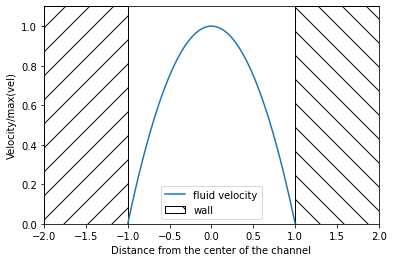

In [17]:
fig, ax = plt.subplots(1)
ax.plot(x_vel,y_vel)
ax.axes.add_patch(Polygon([[1, 0], [2, 0], [2, 1.1],[1, 1.1]], closed=True,
                      fill=False, hatch='\ '))
ax.axes.add_patch(Polygon([[-1, 0], [-2, 0], [-2, 1.1],[-1, 1.1]], closed=True,
                      fill=False, hatch='/'))
plt.xlim([-2,2])
plt.ylim([0,1.1]);
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity/max(vel)');
plt.legend(['fluid velocity','wall']);

## 2.1 Training our first neural network
We'll start with the simplest neural network architecture. A model with one neuron, which is equivalent to a linear regression:

$y=x*w_1+b_1$

We will use mean square error:

$MSE(y_{pred},y)=\frac{1}{N}\sum(y_{pred}-y)^2$

and the ADAM optimizer:

$\theta_{t+1} = \theta_{t}-LR\frac{v_t}{\sqrt{s_t+\epsilon}}\cdot g_t$

Where $v_t$ and $s_t$ are the first and second gradient moments respectively  

In [102]:
model_name = 'nn_class'
rnd_seed   = np.sum( [ord(letter) for letter in model_name] )*123123
np.random.seed( rnd_seed )    # we use this num as the rnd seed for numpy

In [51]:
# Defining our default parameters
loss_f  = 'mse'
optim   = keras.optimizers.Adam
LR      = 0.0001
metrics = 'MAE' #Mean average percentage error

In [52]:
# Setting up our model using the keras library
linear_model = keras.Sequential([keras.layers.Dense(1,input_shape=[1])])
linear_model.compile(loss=loss_f,optimizer=optim(learning_rate=LR), metrics=metrics)
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We have 2 trainable parameters: one weight and one bias

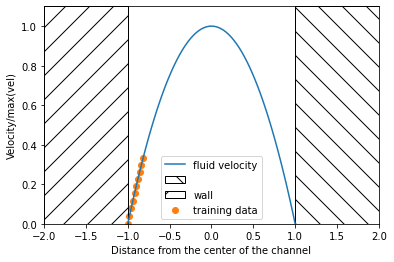

In [53]:
fig, ax = plt.subplots(1)
ax.plot(   x_vel,     y_vel)
ax.scatter(x_vel[:10],y_vel[:10],c='tab:orange')
ax.axes.add_patch(Polygon([[1, 0], [2, 0], [2, 1.1],[1, 1.1]], closed=True,
                      fill=False, hatch='\ '))
ax.axes.add_patch(Polygon([[-1, 0], [-2, 0], [-2, 1.1],[-1, 1.1]], closed=True,
                      fill=False, hatch='/'))
plt.xlim([-2,2])
plt.ylim([0,1.1]);
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity/max(vel)');
plt.legend(['fluid velocity','','wall','training data']);

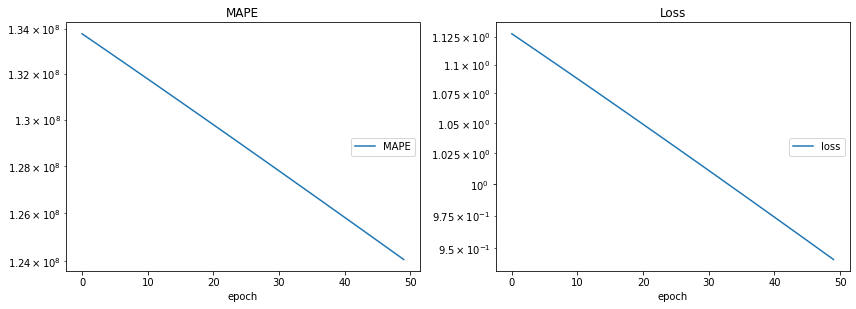

MAPE
	MAPE             	 (min: 124079536.000, max: 133772592.000, cur: 124079536.000)
Loss
	loss             	 (min:    0.941, max:    1.127, cur:    0.941)
1/1 [==============================] - 0s 470ms/step - loss: 0.9415 - MAPE: 124079536.0000


In [54]:
linear_model.fit(x=x_vel[:10], y=y_vel[:10], callbacks=PlotLossesKeras(), epochs=50, validation_split=0)

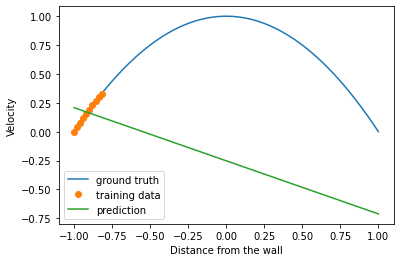

In [66]:
y_pred = linear_model.predict(x=x_vel)

plt.plot(x_vel,y_vel)
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel, y_pred)

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

## 2.1.1 Increasing the learning rate of the model
Although the model was learning during training, this process has been carried very slowly. To speed-up training, we can increase the learning rate.

In [73]:
LR = LR*300
linear_model.compile(loss=loss_f,optimizer=optim(learning_rate=LR), metrics=metrics)

KeyboardInterrupt: 

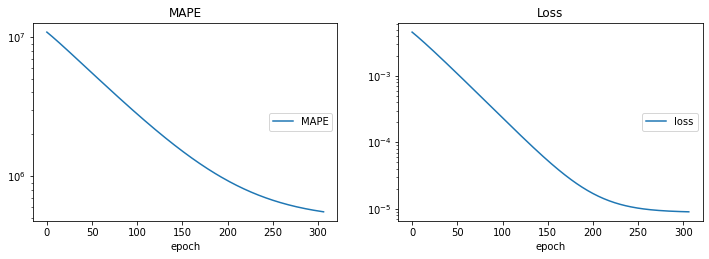

In [74]:
linear_model.fit(x=x_vel[:10], y=y_vel[:10], callbacks=PlotLossesKeras(), epochs=120, validation_split=0)

A good place to stop training is when MSE < 1e-5

In [ ]:
y_pred = linear_model.predict(x=x_vel)

Text(0.5, 1.0, 'NN result close to the training data')

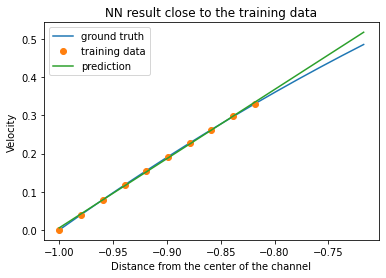

In [79]:
plt.plot(x_vel[:15],y_vel[:15])
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel[:15], y_pred[:15])

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');
plt.title('NN result close to the training data')

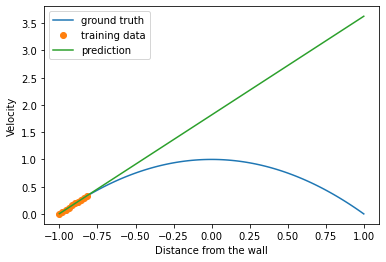

In [80]:
plt.plot(x_vel,y_vel)
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel, y_pred)

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

hmmm that is still not great. Let's try to get a more representative training set.

In [82]:
IDs = np.arange( x_vel.shape[0] ) 
np.random.shuffle( IDs )
x_train = x_vel[ IDs[:10] ]  #get 10 random points
y_train = y_vel[ IDs[:10] ]  #get 10 random points

In [89]:
linear_model.compile(loss=loss_f,optimizer=optim(learning_rate=0.1), metrics=metrics)

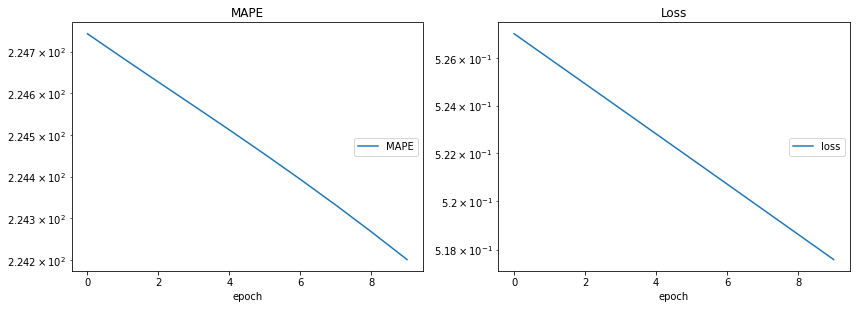

MAPE
	MAPE             	 (min:  224.201, max:  224.743, cur:  224.201)
Loss
	loss             	 (min:    0.518, max:    0.527, cur:    0.518)
1/1 [==============================] - 0s 436ms/step - loss: 0.5176 - MAPE: 224.2009


In [130]:
linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=50, validation_split=0)

In [98]:
y_pred = linear_model.predict(x=x_vel)

Text(0, 0.5, 'Velocity')

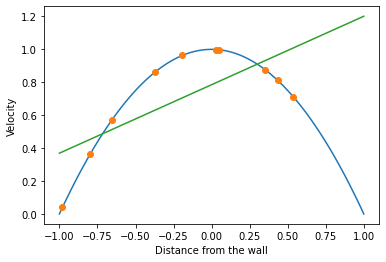

In [99]:
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred)

plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity')

Unfortunately, this model can only have a linear response due to its lack of non-linear activation function.

## 2.2 Training a model with a non-linearity

In [30]:
non_linear_model = keras.Sequential()
non_linear_model.add(keras.layers.Dense(2,activation='selu',input_shape=[1]))
non_linear_model.add(keras.layers.Dense(1,activation='selu'))
non_linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)
non_linear_model.summary()

NameError: name 'loss_f' is not defined

In [29]:
LR=0.1
non_linear_model.compile(loss=loss_f,optimizer=optim(learning_rate=LR), metrics=metrics)
non_linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=75, validation_split=0)

NameError: name 'non_linear_model' is not defined

A good place to stop training is when MSE < 1e-4

In [116]:
y_pred_NL = non_linear_model.predict(x=x_vel)

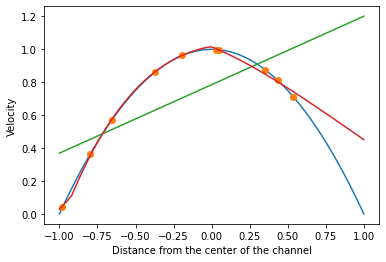

In [118]:
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred)
plt.plot(x_vel, y_pred_NL)


plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

## 2.3 Scientific machine-learning
What if we knew something about the data itself?
For example, if we knew that our dataset was comprised by parabolic profiles, we could add that as a hard constrain into our neural network arquitecture:


In [200]:
def build_linear_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    path   = keras.backend.square(inputs)  # this layers square everything that is passed through here
    path   = keras.layers.Dense(1,activation='linear')(path)
    return keras.models.Model(inputs, path)
    #return keras.models.Model(inputs=inputs, output=path)
    
linear_model = build_linear_model( input_shape=1)
linear_model.summary()


In [201]:
# let's give it the "hard" traing data. 5 points from the left corner
x_train = x_vel[:5]
y_train = y_vel[:5]

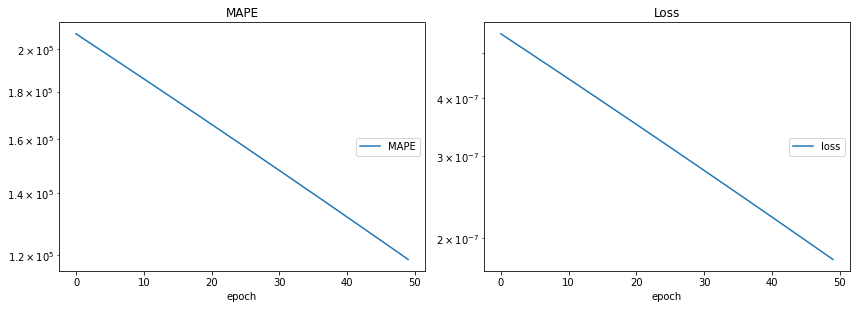

MAPE
	MAPE             	 (min: 118708.891, max: 207901.484, cur: 118708.891)
Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
1/1 [==============================] - 1s 651ms/step - loss: 1.7980e-07 - MAPE: 118708.8906


In [238]:
linear_model.compile(loss=loss_f,optimizer=optim(learning_rate=0.1), metrics=metrics)
linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=50, validation_split=0)

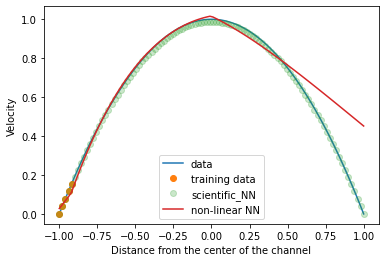

In [237]:
y_pred = linear_model.predict(x=x_vel)
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred, 'o', alpha=0.25)
plt.plot(x_vel, y_pred_NL)

plt.legend(['data','training data','scientific_NN','non-linear NN'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

In [239]:
print(f'The weight of the neuron is {linear_model.weights[0].numpy()[0][0]} with a bias of {linear_model.weights[1].numpy()[0]}')

The weight of the neuron is -0.9923605918884277 with a bias of 0.9929472208023071


A great paper about scientific ML is [rabbits and foxes](https://arxiv.org/abs/2001.04385).

## 2.4 What about 3D data?

In [240]:
def profile_3D(x,y):
    return 1-(x**2 + y**2)

In [241]:
model = keras.Sequential() # as first layer in a sequential model:
# let's define our first 3D model (there is still room from creativity here)
model.add( keras.layers.Dense( units=20, input_shape=(2,) ) )
model.add( keras.layers.Activation(activation='selu') )
model.add( keras.layers.Dense( units=20, input_shape=(20,) ) )
model.add( keras.layers.Activation(activation='selu') )
model.add( keras.layers.Dense( units=1, input_shape=(20,) ) )
model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

In [242]:
x1 = np.array([-1, -1, 0.5, -0.5, 0.1, 0.2, 0.45, 0.9, -0.8,0,1,-1])
x2 = np.array([1, 1, -0.5, 0.5, -0.1, -0.2, -0.45, -0.9, 0.8, 0,1,-1])
y  = profile_3D(x1,x2)

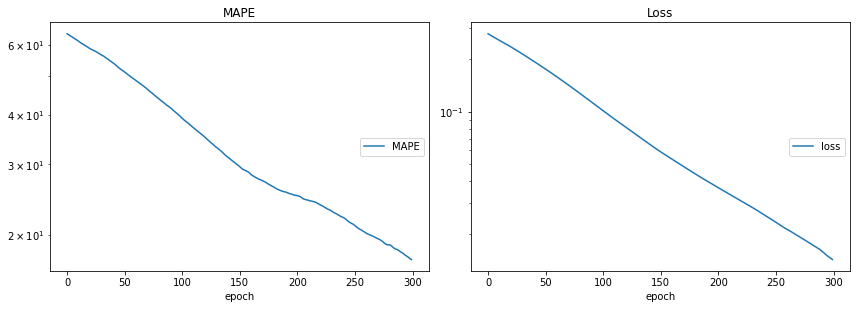

MAPE
	MAPE             	 (min:   17.319, max:   63.836, cur:   17.319)
Loss
	loss             	 (min:    0.014, max:    0.277, cur:    0.014)
1/1 [==============================] - 0s 412ms/step - loss: 0.0143 - MAPE: 17.3187


In [245]:
%matplotlib inline
model.fit(np.stack([x1,x2]).T, y, epochs=50, callbacks=PlotLossesKeras())

In [246]:
x1_test = (np.random.rand(100)-0.5)*2
x2_test = (np.random.rand(100)-0.5)*2
y_true  = profile_3D(x1_test, x2_test)
y_pred  = model.predict(np.stack([x1_test,x2_test]).T).reshape(-1)

<IPython.core.display.Javascript object>


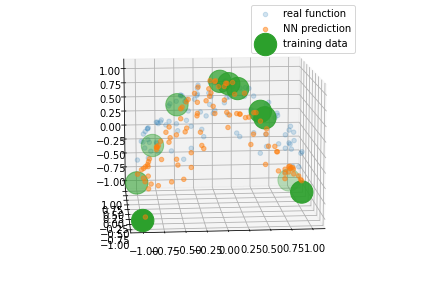

In [249]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1_test, x2_test, y_true, alpha=0.2)
ax.scatter(x1_test, x2_test, y_pred, alpha=0.5)
ax.scatter(x1,x2,y, s=500)
plt.legend(['real function', 'NN prediction','training data'])

# 3.0 Permeability prediction
1) We created a dataset of 2D images using some micromodels presented in: "Process-Based Microfluidics" by Lucas Mejia et al. (2019). This dataset consists on ~800 micromodel subsamples that host a wide variety of lithologies. 

2) We then performed a single-phase lattice Boltzmann simulation to obtain the fluid velocity field in the flow direction. We set pressure bounday conditions perpendicular to the x-axis and iterate under a laminar flow regime until steady-state is achieved.


Our simulation workflow can be found here:

https://github.com/je-santos/MPLBM-UT/tree/master/examples/create_2D_training_data_4NN


## 3.1 Loading the geometries and the simulation data

In [385]:
# load the file
X = np.load('numpys/X.npy')
y = np.load('numpys/y.npy').astype(np.float32)

k   = np.mean(y, axis=(1,2))*100000 #normalize the permeability

# data cleaning (remove non-percolating samples)
def drop_samples(x,ind):
    return x[ind]

indices = np.where(k>0.01) # drop the samples where the permeability is lower than 0.01 [D]
X,y,k   = [drop_samples(array,indices) for array in [X,y,k]]


phi = 1-np.mean(X, axis=(1,2)) # calculating the porosity

In [2]:
## 3.1.1 Defining functions

def get_features(X):
  feature_dict = {}
  eucl_dist, thickness, chords_vert, chords_horz = [np.zeros_like(X) for i in range(4)]
  chord_count_vert, chord_count_horz = [np.empty((X.shape[0],), dtype=object) 
                                                              for i in range(2)]


  for im in range( X.shape[0] ):
      bin_im = -X[im] + 1 # Invert pore and grain space
      eucl_dist[im] = sc.distance_transform_edt(bin_im) # Find Euclidean Distance
      thickness[im] = ps.filters.local_thickness(bin_im, mode='hybrid')
      chords_vert[im] = ps.filters.apply_chords(bin_im, trim_edges=False)
      chord_count_vert[im] = ps.metrics.chord_counts(chords_vert[im])
      chords_horz[im] = ps.filters.apply_chords(bin_im, axis=1, trim_edges=False)
      chord_count_horz[im] = ps.metrics.chord_counts(chords_horz[im])

  feature_dict = {
                  'e_dist':eucl_dist,
                  'inscribed_spheres':thickness,
                  'chords_vert':chords_vert,
                  'chord_count_vert':chord_count_vert,
                  'chords_horz':chords_horz,
                  'chord_count_horz':chord_count_horz
                  }
  return feature_dict

def get_stats(im, keyname):
  stats={}
  image = np.copy(im)
  image = np.where(image==0, np.nan, image)
  try:
    mean = np.nanmean(image, axis=(1,2))
    median = np.nanmedian(image, axis=(1,2))
    std = np.nanstd(image, axis=(1,2))
    p25 = np.nanquantile(image,.25,axis=(1,2))
    p75 = np.nanquantile(image,.75,axis=(1,2))
  except:
    mean, median, std, p25, p75 = [np.zeros_like(image) for i in range(5)]
    for i in range(image.shape[0]):
      mean[i] = np.mean(image[i])
      median[i] = np.median(image[i])
      std[i] = np.std(image[i])
      p25[i] = np.quantile(image[i],.25) 
      p75[i] = np.quantile(image[i],.75)
  
  stats = {
        f'{keyname}mean':mean,
        f'{keyname}median':median,
        f'{keyname}std':std, 
        f'{keyname}p25':p25,
        f'{keyname}p75':p75
         }

  return stats

def minMax(x_train, x_test):
    min_val    = np.min(x_train)
    data_range = np.ptp(x_train)
    
    x_train = (x_train-min_val)/data_range
    x_test  = (x_test -min_val)/data_range
    return x_train, x_test


def shuffle_samples(x,IDs,num_train):
    return x[IDs[:num_train,]],x[IDs[num_train:,]]

In [3]:
print(f'The shape of X is {X.shape} and the shape of y is {y.shape}')
print('                  (Number of examples, x and y)')
print()
print(f'The average porosity is {np.mean(phi)*100:4.1f}% and the average permeability is {np.mean(k):0.2} [Darcy]')

NameError: name 'X' is not defined

## 3.2 Data visualization

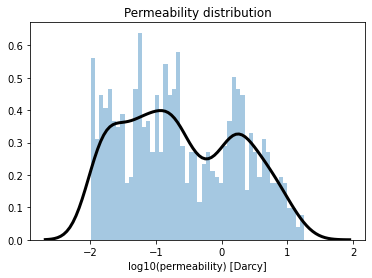

In [387]:
%matplotlib inline
sns.distplot(np.log10(k),bins=50, kde_kws={"color": "k", "lw": 3})
plt.title('Permeability distribution')
plt.xlabel('log10(permeability) [Darcy]');

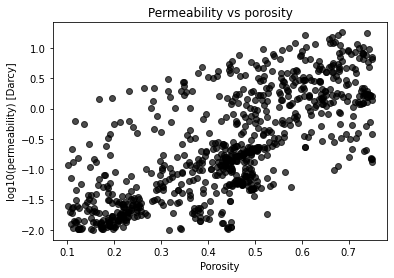

In [388]:
plt.scatter(phi,np.log10(k),c='k',alpha=0.7)
plt.title('Permeability vs porosity')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

IntSlider(value=0, description='Im number', max=792)

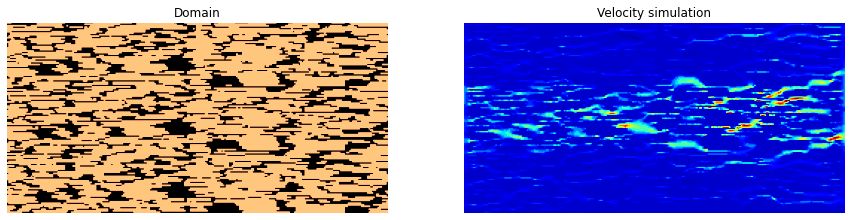

In [389]:
w = widgets.IntSlider()
w.value= 0
w.min =  0
w.max =  X.shape[0]
w.description='Im number'
display(w)

def plot_im(*args):
    clear_output(wait=True)
    display(w)
    
    #plt.figure(dpi=300)
    plt.subplot(1,2,1)
    plt.imshow(X[w.value], cmap='copper', clim=(0,.75))
    plt.axis('off')
    plt.title('Domain')
    plt.subplot(1,2,2)
    plt.imshow(y[w.value], cmap='jet')
    plt.axis('off')
    plt.title('Velocity simulation')
    
    fig = plt.gcf() 
    fig.set_size_inches(15,6)
    
plot_im()
w.observe(plot_im,'value')

## 3.3 Extracting additional features

In the next cell we will extract morpholofical features of the porous structures. This will help the machine to learn correaltions between pore geometry and velocity. This process takes around 2 minutes for 1000 images.

In [ ]:
%%capture
start = time.time()
feature_dict = get_features(X)
stop = time.time()

In [ ]:
print(f'Extracting the features took {(stop-start)/60} minutes')
print(f'The features extracted are: {feature_dict.keys()}')

In [ ]:
# calculating feature statistics
stats_dict = {}
feats = ['e_dist','inscribed_spheres', 'chord_count_horz', 'chord_count_vert']
for feat in feats:
  stats_dict[feat] = get_stats(feature_dict[feat],feat+'_')

In [ ]:
#@title Visualizing the extracted features 

w = widgets.IntSlider()
w.value= 0
w.min =  0
w.max =  X.shape[0]
w.description='Im number'
display(w)

def plot_im(*args):
    clear_output(wait=True)
    display(w)
    
    #plt.figure(dpi=300)
    plt.subplot(4,2,1)
    plt.imshow(X[w.value], cmap=plt.cm.inferno, clim=(0,.75))
    plt.axis('off')
    plt.title('Domain')

    plt.subplot(4,2,2)
    plt.imshow(y[w.value], cmap='jet')
    plt.axis('off')
    plt.title('Velocity simulation')
    
    plt.subplot(4,2,3)
    plt.imshow(feature_dict['e_dist'][w.value], cmap='jet')
    plt.axis('off')
    plt.title('Euclidean distance')

    plt.subplot(4,2,4)
    plt.imshow(feature_dict['inscribed_spheres'][w.value])
    plt.axis('off')
    plt.title('Inscribed spheres')

    plt.subplot(4,2,5)
    plt.imshow(feature_dict['chords_vert'][w.value])
    plt.axis('off')
    plt.title('Vertical chords')
    
    plt.subplot(4,2,6)
    plt.hist(feature_dict['chord_count_vert'][w.value], bins=256)
    plt.axis('off')
    plt.title('Vertical chords histogram')

    plt.subplot(4,2,7)
    plt.imshow(feature_dict['chords_horz'][w.value])
    plt.axis('off')
    plt.title('Horizontal chords')

    plt.subplot(4,2,8)
    plt.hist(feature_dict['chord_count_horz'][w.value], bins=256)
    plt.axis('off')
    plt.title('Horizontal chords histogram')

    fig = plt.gcf() 
    fig.set_size_inches(15,10)
    
plot_im()
w.observe(plot_im,'value')

## 3.4 Splitting and normalizing our data our data
To assess the predictive capabilites of our models we split our data into training and testing. The training data will be seen by the model and will be used to update its internal parameters to reduce the error. The test data will be used to assess how good is the trained model.

In [424]:
split      = 0.8 # fraction of the data that will be used for training
num_train  = int(split*X.shape[0]) # num of samples for training 
print(f'Total samples in the data set: {X.shape[0]}, we will use {num_train} for training')

Total samples in the data set: 792, we will use 633 for training


In [425]:
IDs = np.arange( X.shape[0] ); np.random.shuffle( IDs )
[X_train,X_test],[y_train,y_test],[phi_train,phi_test],[k_train,k_test] = \
                        [shuffle_samples(array,IDs, num_train) for array in [X,y,phi,k]]


tmp_dict = copy.deepcopy(stats_dict)
for feat_key in tmp_dict.keys():
  for stat_key in tmp_dict[feat_key].keys():
    stats_dict[feat_key][stat_key+'_train'], stats_dict[feat_key][stat_key+'_test'] = \
                                                        shuffle_samples(stats_dict[feat_key][stat_key], IDs, num_train)

for feat_key in tmp_dict.keys():
  for stat_key in tmp_dict[feat_key].keys():
    stats_dict[feat_key][stat_key+'_train'], stats_dict[feat_key][stat_key+'_test'] = \
                                minMax(stats_dict[feat_key][stat_key+'_train'], stats_dict[feat_key][stat_key+'_test'])
    
    
tmp_dict = copy.deepcopy(feature_dict)
for stat_key in tmp_dict.keys():
    feature_dict[stat_key+'_train'], feature_dict[stat_key+'_test'] = \
                                        shuffle_samples(feature_dict[stat_key], IDs, num_train)

for stat_key in tmp_dict.keys():
    if stat_key=='chord_count_vert' or stat_key=='chord_count_horz':
      continue
    feature_dict[stat_key+'_train'], feature_dict[stat_key+'_test'] = \
                            minMax(feature_dict[stat_key+'_train'], feature_dict[stat_key+'_test'])

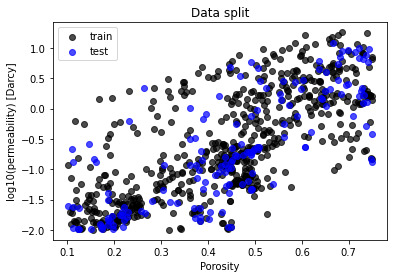

In [392]:
plt.scatter(phi_train,np.log10(k_train),c='k',alpha=0.7)
plt.scatter(phi_test ,np.log10(k_test) ,c='b',alpha=0.7)
plt.legend(['train','test'])
plt.title('Data split')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

In [394]:
k_train = np.log10(k_train)
k_test  = np.log10(k_test )

In [3]:
def linear_model(x):
    return x*3.4527194-2.1689951

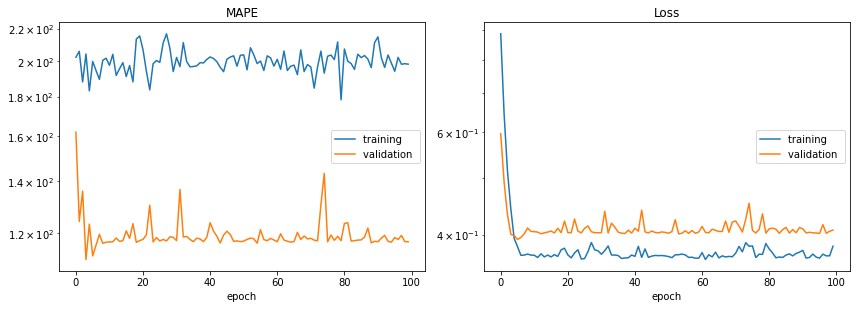

MAPE
	training         	 (min:  178.280, max:  216.826, cur:  198.139)
	validation       	 (min:  111.011, max:  161.945, cur:  116.997)
Loss
	training         	 (min:    0.363, max:    0.886, cur:    0.382)
	validation       	 (min:    0.393, max:    0.597, cur:    0.407)
16/16 [==============================] - 0s 28ms/step - loss: 0.3821 - MAPE: 198.1392 - val_loss: 0.4074 - val_MAPE: 116.9965


In [307]:
#linear_model = keras.Sequential([keras.layers.Dense(1,input_shape=[1])])
#linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)
#linear_model.fit(x=phi_train, y=k_train, callbacks=PlotLossesKeras(), epochs=100, validation_split=0.2)

324.5718596802696


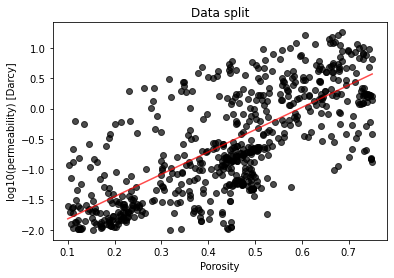

In [308]:
x_test       = np.linspace(0.1,0.75) #plot a curve spanning the entire porosity range
y_testl       = linear_model(x=x_test)
k_linear     = linear_model(x=phi_test)


plt.scatter(phi_train,k_train,c='k',alpha=0.7)
plt.plot(x_test ,y_testl,c='r',alpha=0.7)
plt.title('Data split')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.scatter(stats_dict['chord_count_horz']['chord_count_horz_mean'],np.log10(k),c='k',alpha=0.5)
#plt.title('Permeability vs Mean Horizontal Chord Length')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Mean Horizontal Chord Length');

plt.subplot(1,3,2)
plt.scatter(stats_dict['chord_count_horz']['chord_count_horz_std'],np.log10(k),c='b',alpha=0.5)
#plt.title('Permeability vs Standard Deviation of Horizontal Chord Length')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Standard Deviation of Horizontal Chord Length');

plt.subplot(1,3,3)
plt.scatter(stats_dict['chord_count_vert']['chord_count_vert_mean'],np.log10(k),c='g',alpha=0.5)
#plt.title('Permeability vs Mean Vertical Chord Length')
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Mean Vertical Chord Length');

plt.suptitle('Pairplots of the additional features plotted against permeability')

In [309]:
non_linear_model = keras.Sequential()
                                        # neurons, activation, num_input_features
non_linear_model.add(keras.layers.Dense(10,activation='selu',input_shape=[4,]))
# second layer
non_linear_model.add(keras.layers.Dense(10,activation='selu'))
#
non_linear_model.add(keras.layers.Dense(10,activation='selu'))
# last layer (it has one ouput = permeability)
non_linear_model.add(keras.layers.Dense(1,activation='selu'))

In [319]:
LR = 0.1
non_linear_model.compile(loss=loss_f,optimizer=optim(learning_rate=LR), metrics=metrics)

In [ ]:
x_train = np.stack((phi_train, stats_dict['chord_count_horz']['chord_count_horz_mean_train'], \
                    stats_dict['chord_count_horz']['chord_count_horz_std_train'], \
                    stats_dict['chord_count_vert']['chord_count_vert_mean_train']),axis=-1).astype(np.float32)

x_test_NL = np.stack((phi_test, stats_dict['chord_count_horz']['chord_count_horz_mean_test'], \
                    stats_dict['chord_count_horz']['chord_count_horz_std_test'], \
                    stats_dict['chord_count_vert']['chord_count_vert_mean_test']),axis=-1).astype(np.float32)

print('The shape os the input is: {x_train.shape}')

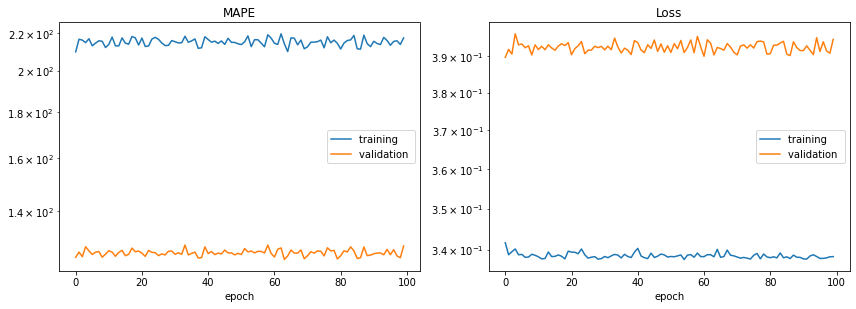

MAPE
	training         	 (min:  209.750, max:  219.601, cur:  217.317)
	validation       	 (min:  123.732, max:  128.369, cur:  128.040)
Loss
	training         	 (min:    0.338, max:    0.342, cur:    0.338)
	validation       	 (min:    0.390, max:    0.396, cur:    0.395)
16/16 [==============================] - 0s 29ms/step - loss: 0.3383 - MAPE: 217.3167 - val_loss: 0.3946 - val_MAPE: 128.0398


In [320]:
non_linear_model.fit(x=x_train, y=k_train, callbacks=PlotLossesKeras(), epochs=100, validation_split=0.2)

In [ ]:
x_test1 = np.linspace(0.1,.8)[:,np.newaxis]
x_test1 = np.stack((x_test1,x_test1,x_test1,x_test1), axis=-1)

y_test1    = non_linear_model.predict(x=x_test1).squeeze()
y_test_NL  = non_linear_model.predict(x=x_test_NL).squeeze()  

356.83360760518497


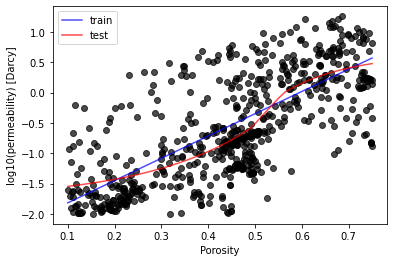

In [323]:
plt.plot(x_test1[:,0,0] ,y_test1,c='b',alpha=0.7, linewidth=5)


error_linear = calc_errror(k_test,k_linear)
error_nonlinear = calc_errror(k_test,y_test_NL)
print(error_linear, error_nonlinear)

plt.scatter(phi_train,k_train,c='k',alpha=0.7)

plt.plot(x_test ,y_testl,c='r',alpha=0.7)

plt.scatter(x_test_NL[:,0] ,y_test_NL ,c='g',alpha=0.7)
plt.legend(['non_linear','linear', 'test set'])
plt.ylabel('log10(permeability) [Darcy]')
plt.xlabel('Porosity');

## 4.0 Velocity field prediction using convolutional neural networks

As we saw on the previous section, not even a model with many neurons and non-linearities is able to fit precisely the 1D relationship between permeability and the other geometrical features. This is due to the lack of spatial context. Porous materials come in different shapes and sizes and host widely different pore shapes and pore size distributions. In this section we will attempt to fit the same data using convolutional neural networks.


![ChessUrl](https://miro.medium.com/max/354/1*1VJDP6qDY9-ExTuQVEOlVg.gif "chess")

In [426]:
X_train,X_test,y_train,y_test = 1-X_train,1-X_test,y_train/np.max(y_train),y_test/np.max(y_train)

In [14]:
# @title Defining the convolutional neural network model
def res_block(x, nb_filters, strides):
    res_path = tf.keras.layers.BatchNormalization()(x)
    res_path = tf.keras.layers.Activation(activation='selu')(res_path)
    res_path = tf.keras.layers.Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = tf.keras.layers.BatchNormalization()(res_path)
    res_path = tf.keras.layers.Activation(activation='selu')(res_path)
    res_path = tf.keras.layers.Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = tf.keras.layers.Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    res_path = tf.keras.layers.add([shortcut, res_path])
    return res_path


def encoder(x, filters):
    to_decoder = []

    main_path = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = tf.keras.layers.BatchNormalization()(main_path)
    main_path = tf.keras.layers.Activation(activation='selu')(main_path)
    main_path = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)
    
    shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    main_path = tf.keras.layers.add([shortcut, main_path])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [filters*2, filters*2], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [filters*4, filters*4], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder, filters):
    main_path = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    main_path = tf.keras.layers.concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [filters*4, filters*4], [(1, 1), (1, 1)])

    main_path = tf.keras.layers.UpSampling2D(size=(2, 2))(main_path)
    main_path = tf.keras.layers.concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [filters*2, filters*2], [(1, 1), (1, 1)])

    main_path = tf.keras.layers.UpSampling2D(size=(2, 2))(main_path)
    main_path = tf.keras.layers.concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [filters, filters], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape,  filters=64):
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    #masks = tf.keras.layers.Input(shape=masks_shape)
    to_decoder = encoder(inputs, filters)

    path = res_block(to_decoder[2], [filters*8, filters*8], [(2, 2), (1, 1)])
    path = decoder(path, from_encoder=to_decoder, filters=filters)
    
    path = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1))(path)
    path = tf.keras.layers.Multiply()([path,inputs])
    
    return tf.keras.models.Model(inputs=inputs, outputs=path)

In [459]:
convnet = build_res_unet(input_shape  = ( None, None, 1 ), filters=8)
convnet.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

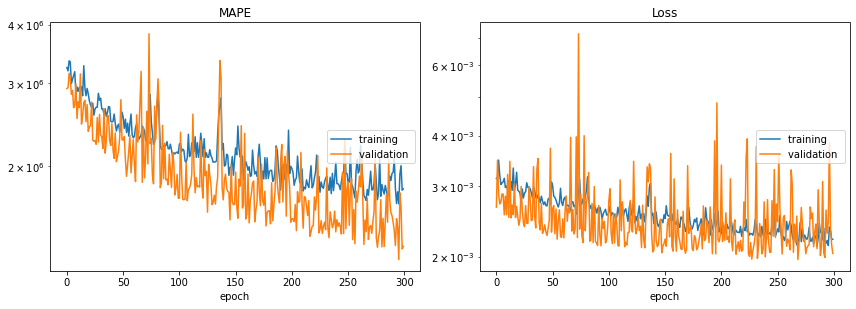

MAPE
	training         	 (min: 1664371.125, max: 3350058.500, cur: 1790028.875)
	validation       	 (min: 1267653.750, max: 3823722.000, cur: 1352330.875)
Loss
	training         	 (min:    0.002, max:    0.003, cur:    0.002)
	validation       	 (min:    0.002, max:    0.007, cur:    0.002)
16/16 [==============================] - 2s 147ms/step - loss: 0.0022 - MAPE: 1790028.8750 - val_loss: 0.0020 - val_MAPE: 1352330.8750


In [465]:
convnet.fit(x=X_train,y=y_train, epochs=100, callbacks=PlotLossesKeras(), validation_split=0.2)

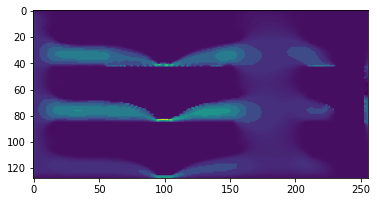

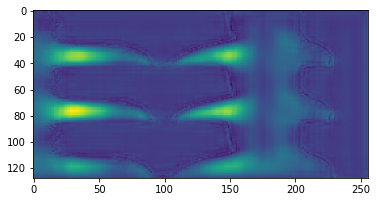

In [455]:
im_num = 0

x=X_test[im_num][np.newaxis,:,:,np.newaxis]
y_pred = convnet.predict(x=x)
plt.imshow(np.squeeze(y_test[im_num]))
plt.figure()
plt.imshow(np.squeeze(y_pred))

In [456]:
y_pred = convnet.predict(x=X_test)

X_test_mean = np.mean(X_test, axis=(1,2))
y_pred_mean = np.mean(y_pred, axis=(1,2))
y_test_mean = np.mean(y_test, axis=(1,2))

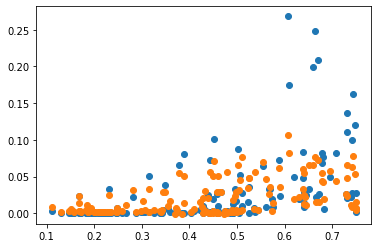

In [457]:
plt.scatter(X_test_mean, y_test_mean)
plt.scatter(X_test_mean, y_pred_mean)

In [ ]:
convnet2 = build_res_unet(input_shape  = ( None, None, 4 ), filters=8)
convnet2.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

In [ ]:
x4train = np.stack((
                    feature_dict['e_dist_train'],
                    feature_dict['inscribed_spheres_train'],
                    feature_dict['chords_horz_train'],
                    feature_dict['chords_vert_train']
                    ), axis=-1 )

y_tmp= y_train[:,:,:,np.newaxis]

In [ ]:
convnet2.fit(x=x4train,y=y_tmp, epochs=100, callbacks=PlotLossesKeras(), validation_split=0.2)

In [ ]:
x4test = np.stack((
                    feature_dict['e_dist_test'],
                    feature_dict['inscribed_spheres_test'],
                    feature_dict['chords_horz_test'],
                    feature_dict['chords_vert_test']
                    ), axis=-1 )

y_tmp= y_test[:,:,:,np.newaxis]

In [ ]:
im_num = 0

x=x4test[im_num][np.newaxis,]
y_pred = convnet2.predict(x=x)
plt.imshow(np.squeeze(y_test[im_num]))
plt.figure()
plt.imshow(np.squeeze(y_pred))